^fill^README.md^here^

- - -

^fill^theory.md^here^

- - -

## Demonstration

### 1. Library imports

Import libraries needed by the calculation. The external libraries used are:

- [numpy](http://www.numpy.org/)

- [pandas](https://pandas.pydata.org/)

- [DataModelDict](https://github.com/usnistgov/DataModelDict)

- [atomman](https://github.com/usnistgov/atomman)

- [iprPy](https://github.com/usnistgov/iprPy)

In [1]:
# Standard library imports
from __future__ import division, absolute_import, print_function
import os
import sys
import uuid
import shutil
import datetime
from copy import deepcopy

# http://www.numpy.org/
import numpy as np 

# https://pandas.pydata.org/
import pandas as pd

# https://github.com/usnistgov/DataModelDict 
from DataModelDict import DataModelDict as DM

# https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

# https://github.com/usnistgov/iprPy
import iprPy

Import plotting library for the Notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

### 2. Assign values for the calculation's run parameters

#### 2.0 Set the calculation's working directory

In [3]:
calc_name = 'stacking_fault_multi'

# Check current working directory
cwd_name = os.path.basename(os.getcwd())

# Change working directory if needed
if cwd_name != calc_name:
    if not os.path.isdir(calc_name):
        os.mkdir(calc_name)
    os.chdir(calc_name)

#### 2.1 Specify system-specific paths

Simple input parameters:

- __lammps_command__ is the LAMMPS command to use.

- __mpi_command__ MPI command for running LAMMPS in parallel. A value of None will run simulations serially.

- __lib_directory__ defines the relative path to the iprPy library. This makes it easier to define paths to reference records later.

In [4]:
lammps_command = 'lmp_serial'
mpi_command = None
lib_directory = '../../../library'

#### 2.2 Specify the potenital and elemental symbols

Simple input parameters:

- __potential_name__ gives the name of the potential_LAMMPS reference record in the iprPy library to use for potential. 

- __symbols__ is a list of the elemental model symbols of potential to associate with the unique atom types of system.

Derived parameters:

- __potential_dir_path__ gives the path for the folder containing the artifacts associated with the potential (i.e. eam.alloy file). If an empty string '' is given, the necessary artifacts are taken as being in the working directory. (Here, it is derived from lib_directory and potential_name.)

- __potential_path__ gives the path to the potential_LAMMPS reference record to use. (Here, it is derived from lib_directory and potential_name.)

- __potential__ is the atomman.lammps.Potential representation of a LAMMPS implemented potential to use. (Here, the class is implemented using potential_path and potential_dir_path.)

In [5]:
potential_name = '1999--Mishin-Y--Ni--LAMMPS--ipr1'
symbols = ['Ni']

# -------------- Derived parameters -------------- #
# Define potential_path and potential_dir_path using lib_directory and potential_name
potential_dir_path = os.path.abspath(os.path.join(lib_directory, 'potential_LAMMPS', potential_name))
potential_path = potential_dir_path + '.json'

# Create potential by loading LAMMPS-potential record
potential = lmp.Potential(potential_path, potential_dir_path)

print('Successfully loaded potential', potential)

Successfully loaded potential 1999--Mishin-Y--Ni--LAMMPS--ipr1


#### 2.3 Specify the prototype unit cell system

Simple input parameters:

- __prototype_name__ gives the name of the crystal_prototype reference record in the iprPy library to use for ucell. 

- __box_parameters__ defines the box parameters to scale ucell to. This is a list of either three or six floats
    - __[a, b, c]__ are the orthogonal lattice parameters in length units.
    - __[a, b, c, alpha, beta, gamma]__ are the triclinic lattice parameters in length units and angles in degrees.

Derived parameters:

- __prototype_path__ gives the path to the crystal_prototype reference record to use. (Here, it is derived from lib_directory and prototype_name).

- __ucell__ is an atomman.System representing a fundamental unit cell of the system. (Here, it is loaded from prototype_path file, then scaled using box_parameters).

In [6]:
prototype_name = 'A1--Cu--fcc'
box_parameters = uc.set_in_units([3.52, 3.52, 3.52], 'angstrom')

# -------------- Derived parameters -------------- #
# Define prototype_path using lib_directory and prototype_name
prototype_path = os.path.abspath(os.path.join(lib_directory, 'crystal_prototype', prototype_name+'.json'))

# Create ucell by loading prototype record
ucell = am.load('system_model', prototype_path)[0]

# Rescale ucell using box_parameters
if len(box_parameters) == 3:
    ucell.box_set(a=box_parameters[0], b=box_parameters[1], c=box_parameters[2], scale=True)
elif len(box_parameters) == 6:
    ucell.box_set(a=box_parameters[0], b=box_parameters[1], c=box_parameters[2], scale=True,
                  alpha=box_parameters[3], beta=box_parameters[4], gamma=box_parameters[5])

print(ucell)

avect =  [ 3.520,  0.000,  0.000]
bvect =  [ 0.000,  3.520,  0.000]
cvect =  [ 0.000,  0.000,  3.520]
origin = [ 0.000,  0.000,  0.000]
natoms = 4
natypes = 1
     id |   atype |  pos[0] |  pos[1] |  pos[2]
      0 |       1 |   0.000 |   0.000 |   0.000
      1 |       1 |   0.000 |   1.760 |   1.760
      2 |       1 |   1.760 |   0.000 |   1.760
      3 |       1 |   1.760 |   1.760 |   0.000


#### 2.4 Specify the defect 

Simple input parameters:

- __stackingfault_name__ gives the name of the stacking_fault reference record in the iprPy library to use for potential. 

Derived parameters:

- __stackingfault_path__ gives the path to the stacking_fault reference record to use. (Here, it is derived from lib_directory and stackingfault_name).

- __stackingfault_model__ is a DataModelDict of a stacking_fault record. (Here, the stackingfault_path file is loaded as a DataModelDict.)

- __stackingfault_kwargs__ is a dictionary containing parameters for generating the defect. Values are extracted from the stackingfault_model record and uniquely define a type of stacking fault. Included keywords are:

    - __crystallographic-axes__ specifies how to orient the system. Subelements define each of the x-, y-, and z-axes.
    
    - __cutboxvector__ specifies which box vector to apply the free surface cut to.
    
    - __atomshift__ is a 3D vector rigid-body shift to apply to atoms in the system. The atomshift vector is relative to the rotated unit cell's box vectors.
    
    - __plane-position__ specifies the location to place the fault plane relative to the box vector being cut of the rotated unit cell. 
    
    - __shift-vector-1, shift-vector-2__ are two non-parallel crystallographic shifting vectors within the fault plane.

In [7]:
stackingfault_name = 'A1--Cu--fcc--111sf'

# -------------- Derived parameters -------------- #
# Define stackingfault_path using lib_directory and stackingfault_name
stackingfault_path = os.path.abspath(os.path.join(lib_directory, 'stacking_fault', stackingfault_name+'.json')) 

# Load stacking-fault record as a DataModelDict
with open(stackingfault_path) as f:
    stackingfault_model = DM(f)

print('Successfully loaded defect record for', stackingfault_model['stacking-fault']['id'])

# Extract defect parameters    
stackingfault_kwargs = stackingfault_model['stacking-fault']['calculation-parameter']

print(stackingfault_kwargs.json(indent=4))

Successfully loaded defect record for A1--Cu--fcc--111sf
{
    "x_axis": " 1 -1  0", 
    "y_axis": " 1  1 -2", 
    "z_axis": " 1  1  1", 
    "atomshift": " 0.01  0.01  0.01", 
    "cutboxvector": "c", 
    "faultpos": 0.5, 
    "shiftvector1": " 0.5 -0.5  0.0", 
    "shiftvector2": " 0.5  0.5 -1.0"
}


#### 2.5 Generate the initial system

Simple input parameters:

- __sizemults__ list of three integers or three tuple pairs of integers specifying how many times (and in which direction) the ucell vectors of $a$, $b$ and $c$ are replicated in creating system.

Defect model parameters:

- __x_axis__ is the 3D crystal vector relative to ucell to align with the x-axis of system.

- __y_axis__ is the 3D crystal vector relative to ucell to align with the y-axis of system.

- __z_axis__ is the 3D crystal vector relative to ucell to align with the z-axis of system.

- __atomshift__ is a 3D vector rigid-body shift to apply to atoms in the system. The atomshift vector is relative to the rotated unit cell's box vectors.

Derived parameters:

- __axes__ is a 3x3 array combining x_axis, y_axis and z_axis.

- __shift__ is a 3D vector rigid-body shift to apply to atoms in the system. The shift vector is in absolute Cartesian units. (Here, it is derived from atomshift).

- __system__ is the base atomman.System to use. (Here, it is derived by copying ucell, rotating according to axes, applying shift, then sizemults

In [8]:
sizemults = [5,5,5]

# -------------- Defect parameters --------------- #
x_axis = np.array(stackingfault_kwargs['x_axis'].split(), dtype=float)
y_axis = np.array(stackingfault_kwargs['y_axis'].split(), dtype=float)
z_axis = np.array(stackingfault_kwargs['z_axis'].split(), dtype=float)
atomshift = np.array(stackingfault_kwargs['atomshift'].split(), dtype=float)

# -------------- Derived parameters -------------- #
# Copy ucell to initialsystem
system = deepcopy(ucell)

# Build axes from x_axis, y_axis and z_axis
axes = np.array([x_axis, y_axis, z_axis])

# Rotate using axes
system = am.rotate_cubic(system, axes)

# Convert atomshift to shift using the rotated system
shift = (atomshift[0] * system.box.avect 
         + atomshift[1] * system.box.bvect 
         + atomshift[2] * system.box.cvect)

# Apply shift
system.atoms_prop(key='pos', value=system.atoms_prop(key='pos') + shift)

# Apply sizemults
system.supersize(*sizemults)

print('# of atoms in system =', system.natoms)

# of atoms in system = 3000


#### 2.6 Specify calculation-specific run parameters

Simple input parameters:

- __numshifts1__ is the number of shifts to take along shiftvector1.

- __numshifts2__ is the number of shifts to take along shiftvector2.

- __energytolerance__ is the energy tolerance to use during the minimizations. This is unitless.

- __forcetolerance__ is the force tolerance to use during the minimizations. This is in energy/length units.

- __maxiterations__ is the maximum number of minimization iterations to use.

- __maxevaluations__ is the maximum number of minimization evaluations to use.

- __maxatommotion__ is the largest distance that an atom is allowed to move during a minimization iteration. This is in length units.

Defect model parameters

- __cutboxvector__ defines which of the three system box vector boundaries ($a$, $b$, or $c$) the system will be cut along to create the free surface.

- __planepos_ucell__ specifies the location to place the fault plane relative to the box vector being cut of the rotated unit cell.

- __shiftvector1_crystal__ is a 3D crystal vector relative to ucell that defines one of the shiftvectors.

- __shiftvector2_crystal__ is a 3D crystal vector relative to ucell that defines one of the shiftvectors.

Derived parameters

- __T__ is the transformation matrix associated with axes.

- __shiftvector1__ is one of the shiftvectors in absolute Cartesian units. This is obtained by scaling shiftvector1_crystal by the unit cell box vectors, and then transforming to the defined axes.

- __shiftvector2__ is one of the shiftvectors in absolute Cartesian units. This is obtained by scaling shiftvector2_crystal by the unit cell box vectors, and then transforming to the defined axes.

- __planepos__ is the fractional position to place the fault plane relative to the full initial system. This is derived using planepos_ucell and sizemults such that the fault is placed in one of the middle cell replicas, and always in the same relative position within the cell replica.

In [9]:
numshifts1 = 11
numshifts2 = 11

energytolerance = 1e-8
forcetolerance = uc.set_in_units(0.0, 'eV/angstrom')
maxiterations = 10000
maxevaluations = 100000
maxatommotion = uc.set_in_units(0.01, 'angstrom')

# -------------- Defect parameters --------------- #
planepos_ucell = float(stackingfault_kwargs['faultpos'])
cutboxvector = stackingfault_kwargs['cutboxvector']
shiftvector1_crystal = np.array(stackingfault_kwargs['shiftvector1'].split(), dtype=float)
shiftvector2_crystal = np.array(stackingfault_kwargs['shiftvector2'].split(), dtype=float)

# -------------- Derived parameters -------------- #
# Scale and transform the shiftvectors
T = am.tools.axes_check(axes)
shiftvector1 = T.dot(shiftvector1_crystal[0] * ucell.box.avect + 
                     shiftvector1_crystal[1] * ucell.box.bvect + 
                     shiftvector1_crystal[2] * ucell.box.cvect)

shiftvector2 = T.dot(shiftvector2_crystal[0] * ucell.box.avect + 
                     shiftvector2_crystal[1] * ucell.box.bvect + 
                     shiftvector2_crystal[2] * ucell.box.cvect)

# Define planepos shift function
def shift_planepos(p, m):
    """This shifts planepos, p, based on system multiplier, m"""
    # If m is odd, keep p=0.5 at 0.5 
    if m % 2 == 1: 
        return (p + (m-1) * 0.5) / m        
    # If m is even, keep p=0.0 at 0.5
    else:          
        return (2 * p + m) / (2 * m)

# Convert planepos_ucell to planepos
if   cutboxvector == 'a': m = sizemults[0]
elif cutboxvector == 'b': m = sizemults[1]
elif cutboxvector == 'c': m = sizemults[2]
    
if isinstance(m, (list, tuple)):
    m = m[1] - m[0]
    
faultpos = shift_planepos(planepos_ucell, m)

### 3. Define calculation function(s) and generate template LAMMPS script(s)

#### 3.1 sfmin.template

In [10]:
with open('sfmin.template', 'w') as f:
    f.write("""^fill^sfmin.template^here^""")

#### 3.2 stackingfaultpoint()

In [11]:
^fill^calc_stacking_fault_multi.py(stackingfaultpoint)^here^

#### 3.3 stackingfaultworker()

In [12]:
^fill^calc_stacking_fault_multi.py(stackingfaultworker)^here^

#### 3.4 stackingfaultmap()

In [13]:
^fill^calc_stacking_fault_multi.py(stackingfaultmap)^here^

### 4. Run calculation function(s)

In [14]:
results_dict = stackingfaultmap(lammps_command, 
                                system, 
                                potential,
                                symbols,  
                                shiftvector1, 
                                shiftvector2,
                                mpi_command = mpi_command,
                                numshifts1=numshifts1, 
                                numshifts2=numshifts2,
                                cutboxvector = cutboxvector,
                                faultpos = faultpos,
                                etol = energytolerance,
                                ftol = forcetolerance,
                                maxiter = maxiterations,
                                maxeval = maxevaluations,
                                dmax = maxatommotion)

In [15]:
results_dict.keys()

['shift2', 'E_gsf', 'shift1', 'A_fault', 'delta_disp']

### 5. Report results

#### 5.1 Define units for outputting values

- __length_unit__ is the unit of length to display results in.
- __energy_unit__ is the unit of energy to display cohesive energies in.
- __e_A_unit__ is the energy per area to report the surface energy in.

In [16]:
length_unit = 'angstrom'
energy_unit = 'eV'

#e_A_unit = energy_unit+'/'+length_unit+'^2'
e_A_unit = 'mJ/m^2'

#### 5.2 Print $A_{fault}$, $E_{gsf}$, and $\Delta\delta$

In [17]:
print('A_fault = ', uc.get_in_units(results_dict['A_fault'], length_unit+'^2'), length_unit+'^2')

A_fault =  1073.04011631 angstrom^2


In [18]:
print('E_gsf = ', uc.get_in_units(results_dict['E_gsf'], e_A_unit), e_A_unit)

E_gsf =  [    0.           120.87637239   411.169457     691.62388707   861.64330527
   924.33783363   861.64330527   691.62388707   411.169457     120.87637239
     0.           220.54010034   411.169457     790.22904431  1131.52787667
  1303.35185675  1363.92118141  1303.35185675  1131.52787667   790.22904431
   411.169457     220.54010034   350.37651541   510.84206753   861.64330527
  1189.06473853  1363.92118142  1426.25731235  1363.92118139  1189.06473853
   861.64330527   510.84206753   350.37651541   153.27188526   293.02173539
   573.40255275   861.64330527  1056.68767291  1131.52787665  1056.68767291
   861.64330527   573.40255275   293.02173539   153.27188526   293.02173539
   301.01156327   350.37651541   399.05166518   411.169457     419.18835735
   411.169457     399.05166518   350.37651541   301.01156327   293.02173539
   924.33783363   861.64330527   691.62388707   411.169457     120.87637239
     0.           120.87637239   411.169457     691.62388707   861.64330527
   

In [19]:
print(results_dict['shift1'])
print(results_dict['shift2'])

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7
  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.
  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8
  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1
  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
  1. ]
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1  0.1  0.1  0.1
  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.4
  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.4  0.5  0.5  0.5  0.5  0.5
  0.5  0.5  0.5  0.5  0.5  0.5  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6  0.6
  0.6 

In [20]:
x, y = np.meshgrid(np.linspace(0,1,numshifts1), np.linspace(0,1,numshifts2))

ValueError: need more than 1 value to unpack

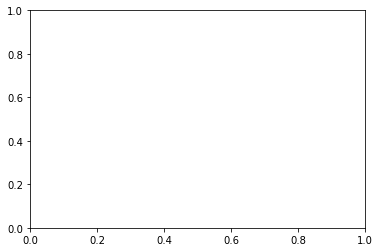

In [21]:
plt.pcolormesh(x, y, uc.get_in_units(results_dict['E_gsf'], e_A_unit))

In [ ]:
def meshsorter(x, y, z):
    